In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/glove-6b-50d/glove.6B.50d.txt


## 1. Introduction

This project aims to train a LSTM for classifying tweets to distinguish tweets that are actually talking about disasters that had occured, or tweets that used figurative language but are in fact unrelated to actual disasters.


## 2. Import libraries and data

In [2]:
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import LSTM, GRU, Dense, GlobalMaxPool2D, GlobalMaxPool1D, Embedding, BatchNormalization, Dropout
from keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


2024-06-23 00:12:18.088267: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 00:12:18.088388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 00:12:18.228095: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

## 3. EDA

In [4]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df.shape

(7613, 5)

In [6]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
test_df.shape

(3263, 4)

As we can see from the snipets of data, we have 5 columns in the training set, with 7613 rows. The actual tweet is in 'text'. Location and keyword (which I assume is the hashtag) are quite empty, we should be careful with how we handle them if much of them are missing values.

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


From the info above we can see that there are no empty value for the actual tweet data in 'text' column, but there are some missing values in keyword and most missing value in location.

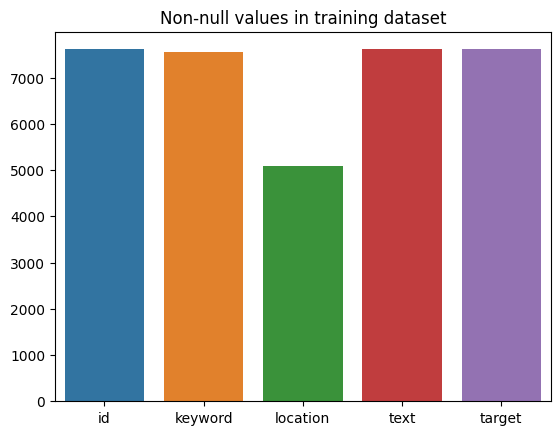

In [10]:
# plot the non-null values
train_not_nulls = train_df.notnull().sum()

sns.barplot(x=train_not_nulls.index, y=train_not_nulls.values)
plt.title("Non-null values in training dataset")
plt.show()

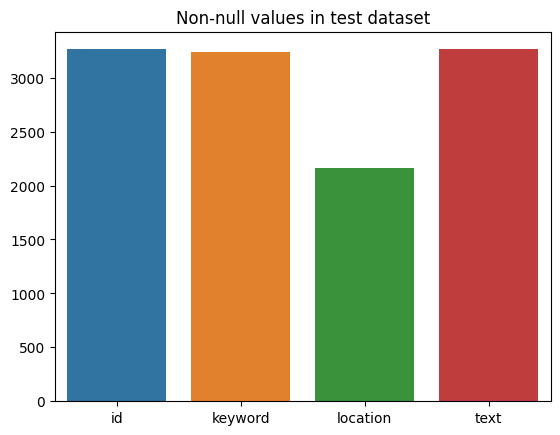

In [11]:
# plot the non-null values for test data
test_not_nulls = test_df.notnull().sum()

sns.barplot(x=test_not_nulls.index, y=test_not_nulls.values)
plt.title("Non-null values in test dataset")
plt.show()

So location seems to have the most missing info, but we have to handle this very carefully. We should probably not just simply get rid of data with missing cell, because the absent of location itself can already be an important feature. (Imagine people may be more likely to add specific location as a warning for the others?)

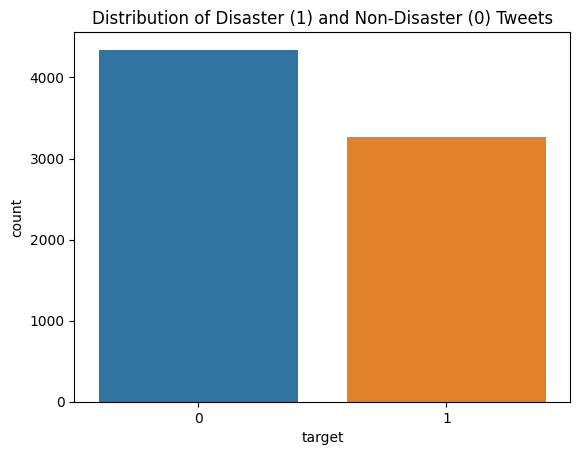

In [12]:
# Plotting target distribution
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Disaster (1) and Non-Disaster (0) Tweets')
plt.show()

Seems like we have a roughly balanced dataset.

Now let's take a closer look at the characteristics between different types of tweets.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Disaster Tweets')

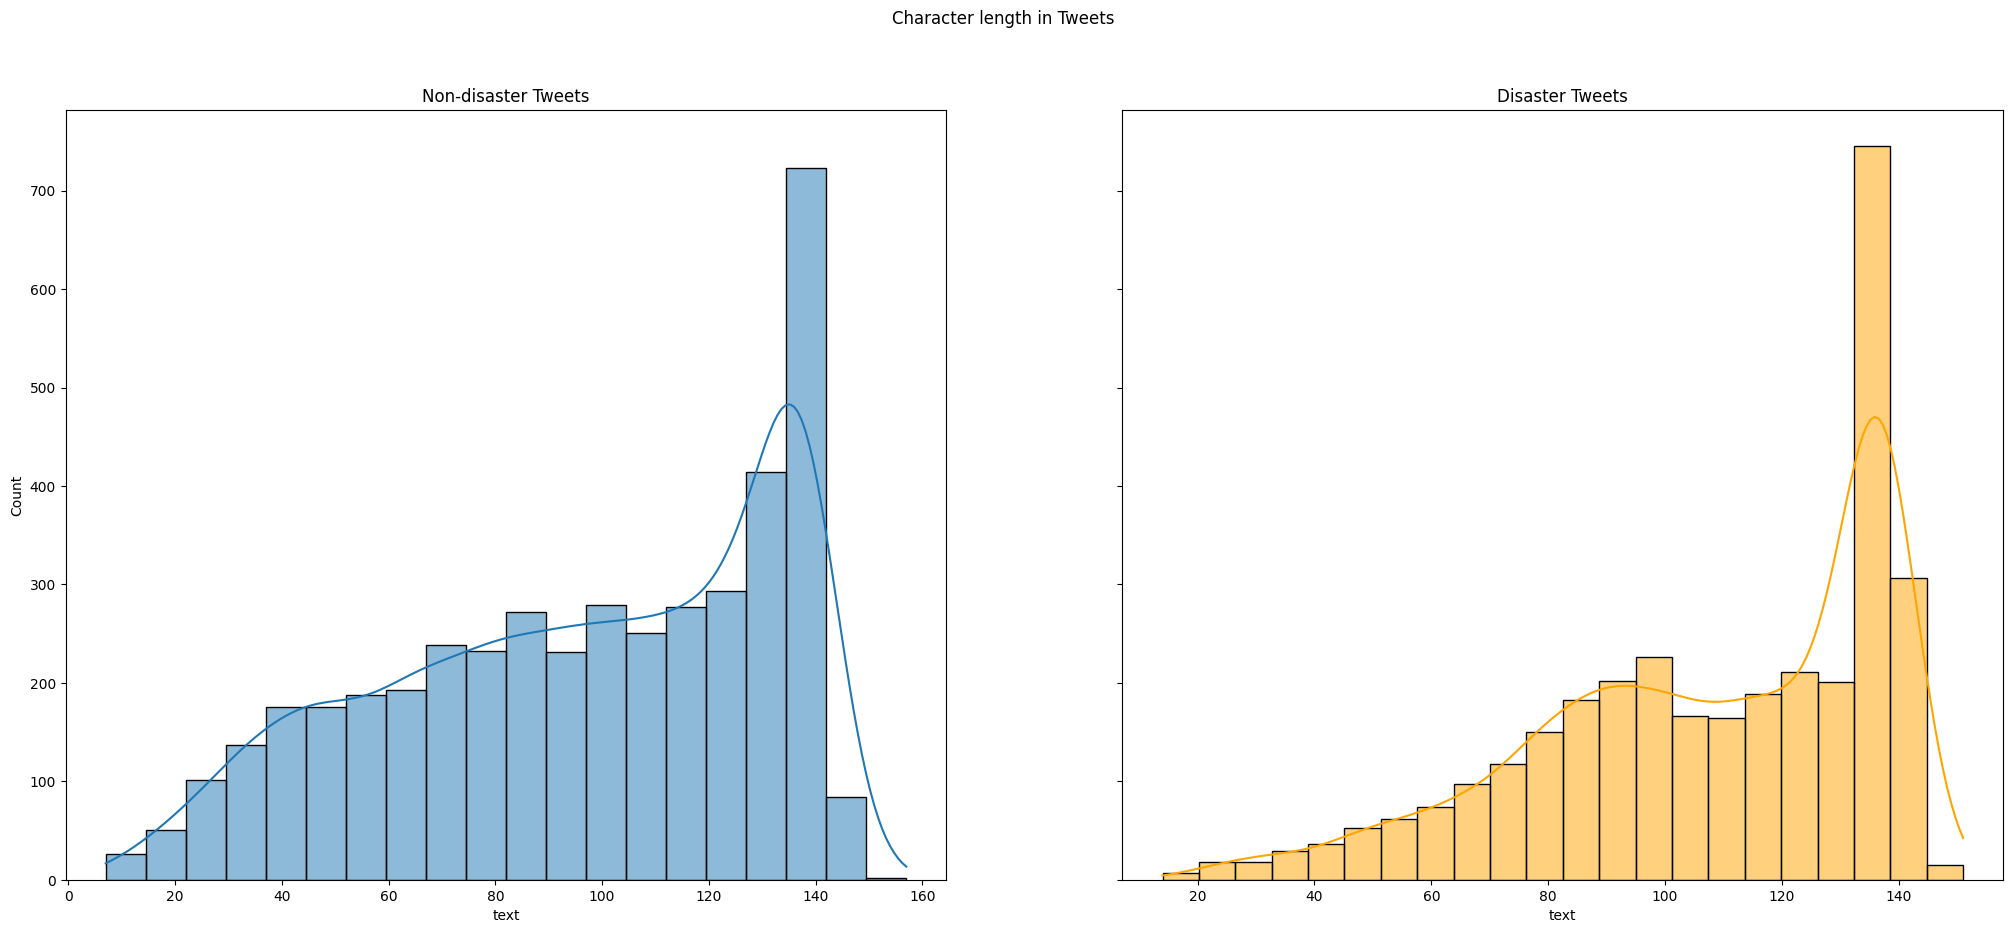

In [13]:
# compare the character lengths

fig, axes = plt.subplots(1, 2, figsize=(25, 10), sharey=True)
fig.suptitle("Character length in Tweets")

tweets0 = train_df[train_df["target"] == 0]["text"].apply(len)

sns.histplot(data=tweets0, kde=True, ax=axes[0])
axes[0].set_title("Non-disaster Tweets")



tweets1 = train_df[train_df["target"] == 1]["text"].apply(len)

sns.histplot(data=tweets1, kde=True, ax=axes[1], color="orange")
axes[1].set_title("Disaster Tweets")



As tweeter only allowed for 140 characters, no tweets can exceed the character length. Solely from the distribution of the tweet length, there seems to be a slight peak for disaster tweets at around 110 characters.

Nonetheless, the overall distributions seem to be not so different.

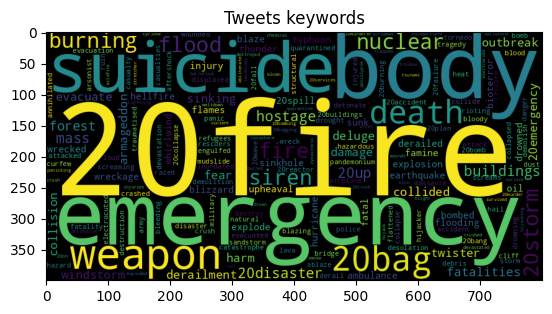

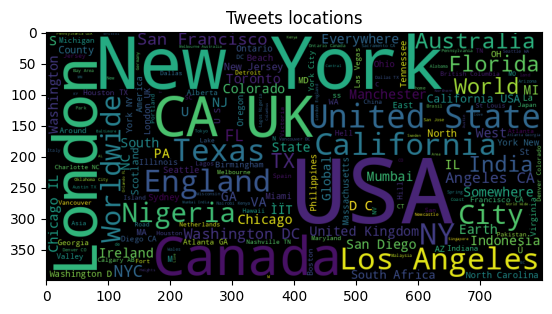

In [14]:
# Use wordcloud to visualize popular keywords and locations
from wordcloud import WordCloud


train_df["keyword"] = train_df["keyword"].fillna("")
train_df["location"] = train_df["location"].fillna("")


all_keywords = ' '.join(train_df["keyword"])
all_locations = ' '.join(train_df["location"])

keyword_cloud = WordCloud(width=800, height=400, collocations=False).generate(all_keywords)
location_cloud = WordCloud(width=800, height=400).generate(all_locations)

plt.imshow(keyword_cloud)
plt.title("Tweets keywords")
plt.show()

plt.imshow(location_cloud)
plt.title("Tweets locations")
plt.show()


The keywords indeed seems quite disastrous, and often with number 20 attached to them, which could be a result of http protocol.

The locations are mostly English speaking countries, which is actually not surprising as the tweets are in English.

## 4. Preprocessing

For NLP tasks, data cleaning is a crucial step in preprocessing, as the texts need to be turned to a standard form for it to be compatible with other tools during the later tokenization and vectorization process.

Effective data cleaning will also ensure consistency during the training process, that is, to consistanly recognize "apple", "Apple", "APPLE" all as the same word instead of three different words.


### 4.1 Data cleaning

In [15]:
# Transform text to lowercase, remove text in square brackets, urls, punctuation and number
import string

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [16]:
train_df["text"] = train_df["text"].apply(lambda x: clean_text(x))
test_df["text"] = test_df["text"].apply(lambda x: clean_text(x))

In [17]:
# get rid of the emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [18]:
train_df["text"] = train_df["text"].apply(lambda x: remove_emoji(x))
test_df["text"] = test_df["text"].apply(lambda x: remove_emoji(x))

In [19]:
# expand abbreviations

contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))
def expand_contractions(s, contractions = contractions):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, s)


In [20]:
train_df["text"] = train_df["text"].apply(lambda x: expand_contractions(x))
test_df["text"] = test_df["text"].apply(lambda x: expand_contractions(x))

In [21]:
# Normalize unicode in tweets
import unicodedata

def normalize_unicode(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')

In [22]:
train_df["text"] = train_df["text"].apply(lambda x: normalize_unicode(x))
test_df["text"] = test_df["text"].apply(lambda x: normalize_unicode(x))

In [23]:
# remobe the english stop words
from nltk import corpus
stop_words = corpus.stopwords.words('english')

def remove_stopwords(text):
    return ' '.join(w for w in text.split(' ') if w not in stop_words)

In [24]:
train_df["text"] = train_df["text"].apply(lambda x: remove_stopwords(x))
test_df["text"] = test_df["text"].apply(lambda x: remove_stopwords(x))

In [25]:
print(train_df["text"])
print(test_df["text"])

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3        people receive wildfires evacuation orders ca...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    ariaahrary thetawniest control wild fires cali...
7610                                      volcano hawaii 
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object
0                             happened terrible car crash
1       heard earthquake different cities stay safe ev...
2       forest fire spot pond geese fleeing across str...
3                   apocalypse lighting spokane wildfires
4                    typhoon soudelor kills  china taiwan
                              ..

### 4.2 Tokenization

Now we need chop up the longer sentences in the tweets into smaller chunks for processing. This is the first step that we turn raw texts into something the algorithm can obsorb and learn from. 

In [26]:
train_tweets = train_df["text"].copy()
test_tweets = test_df["text"].copy()

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# initialize & fit the training data
t = Tokenizer()
t.fit_on_texts(train_tweets)

# encode texts to integer sequences
seq_train = t.texts_to_sequences(train_tweets)
seq_test = t.texts_to_sequences(test_tweets)

# print(seq_train)

In [28]:
# now we need to pad the sequences to have equal lenths

maxlen = 50 # about 4-5 words per sequence

padded_train = pad_sequences(seq_train, maxlen=maxlen, padding="post")
padded_test = pad_sequences(seq_test, maxlen=maxlen, padding="post")

print(padded_train)

[[4161  721  142 ...    0    0    0]
 [  93    4  124 ...    0    0    0]
 [1511 1389 1880 ...    0    0    0]
 ...
 [ 458 1378    0 ...    0    0    0]
 [  17  950 2895 ...    0    0    0]
 [ 111  106  409 ...    0    0    0]]


### 4.3 Vectorization

In our project I will use embedding technique to create dense vectors to represent the words. Where the words have similar meaning will be closer to each other in the high dimensional space. 

Often embeddings will capture more contextual information than tf-idf, therefore, it seems to be more appropriate for our purpose.

We can either use some pre-trained embedding models, or we can train our own. Considering our data size and and complexity of the project, we will use a pre-trained model for better performance.

In this project we will be using GloVe 6B embeddings, the download link is here -> https://nlp.stanford.edu/projects/glove/

In [29]:
# load the embeddings 
embeddings_index = {}
f = open("/kaggle/input/glove-6b-50d/glove.6B.50d.txt")

for line in f:
    vals = line.split()
    word = vals[0]
    coefs = np.asarray(vals[1:], dtype='float32')
    embeddings_index[word] = coefs
    
f.close()
print(len(embeddings_index))

400000


In [30]:
# Now we need to create an embedding matrix that we can use in our model
embedding_dim = 50

embedding_matrix = np.zeros((len(t.word_index) + 1, embedding_dim))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Up to here we have prepared the embeddings to use in our model, now we should define our model architecture and start training.

## 5. Model architecture and training

In [31]:
# First split our training dataset to training and validation set
label = train_df["target"]
X_train,X_val,y_train,y_val= train_test_split(padded_train, label, test_size=0.2, random_state=123)

In [33]:
print(y_train)
print(y_val)

6445    1
3870    1
2431    0
5355    1
6496    0
       ..
4060    1
1346    1
3454    0
7533    1
3582    1
Name: target, Length: 6090, dtype: int64
1971    0
2502    0
5371    0
6258    0
549     0
       ..
513     1
2026    1
1542    0
6438    1
2120    0
Name: target, Length: 1523, dtype: int64


In [ ]:
# y_train = np.argmax(y_train, axis=1)
# y_val = np.argmax(y_val, axis=1)

### 5.1 Basic LSTM

In [34]:
# define our model
model = Sequential()

# define the mebedding layer
model.add(Embedding(input_dim=len(t.word_index) + 1, 
                    output_dim=embedding_dim,
                    weights=[embedding_matrix], 
                    input_length=maxlen, 
                    trainable=False))

model.add(LSTM(100))
model.add(Dense(1, "sigmoid"))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [35]:
# compile the model 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       833,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 833,550 (3.18 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 833,550 (3.18 MB)

In [36]:
# start training
history= model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=10)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.7176 - loss: 0.5511 - val_accuracy: 0.7715 - val_loss: 0.4915
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.7985 - loss: 0.4692 - val_accuracy: 0.7978 - val_loss: 0.4609
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.8029 - loss: 0.4554 - val_accuracy: 0.7932 - val_loss: 0.4638
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8044 - loss: 0.4454 - val_accuracy: 0.8024 - val_loss: 0.4694
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8207 - loss: 0.4468 - val_accuracy: 0.7853 - val_loss: 0.4621
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8168 - loss: 0.4325 - val_accuracy: 0.7965 - val_loss: 0.4665
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8301 - loss: 0.4228 - val_accuracy: 0.7984 - val_loss: 0.4604
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8352 - loss: 0.4016 - val_accu

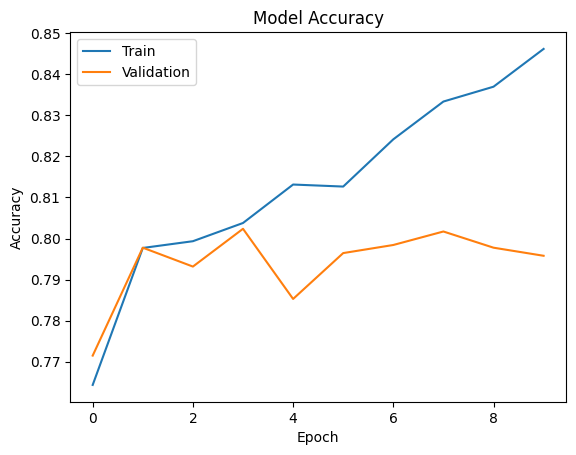

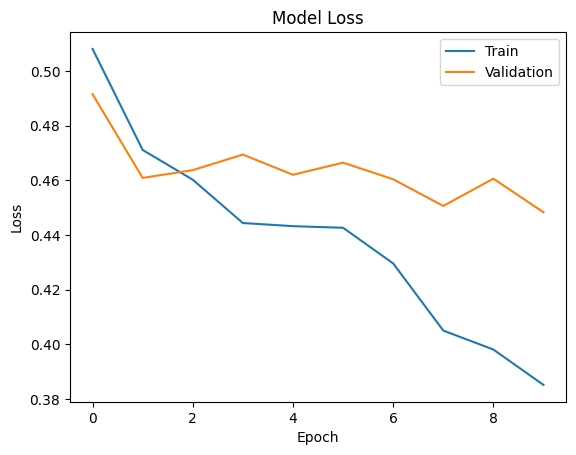

In [37]:
# plot the metrics
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

From the training result we can see that both validation accuracy and validation loss have small amount of fluctuation.

The model had diverged at the 2nd epoch, and then started to have steadily increasing train accuracy and reduced train loss, which is indicating overfitting.

Let's try change the model architecture by adding some batch nomalization and dropout layers.

### 5.2 Second iteration LSTM

In [38]:
# define our model
model2 = Sequential()

# define the mebedding layer
model2.add(Embedding(input_dim=len(t.word_index) + 1, 
                    output_dim=embedding_dim,
                    weights=[embedding_matrix], 
                    input_length=maxlen, 
                    trainable=False))
model2.add(LSTM(100))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(1, "sigmoid"))

In [39]:
# compile the model 
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │       833,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 833,550 (3.18 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 833,550 (3.18 MB)

In [40]:
# start training
history2= model2.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=10)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.7454 - loss: 0.5435 - val_accuracy: 0.7229 - val_loss: 0.6346
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8030 - loss: 0.4628 - val_accuracy: 0.7498 - val_loss: 0.5328
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8107 - loss: 0.4531 - val_accuracy: 0.8011 - val_loss: 0.4669
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8101 - loss: 0.4456 - val_accuracy: 0.6770 - val_loss: 0.5936
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8109 - loss: 0.4391 - val_accuracy: 0.7997 - val_loss: 0.4502
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.8235 - loss: 0.4124 - val_accuracy: 0.7833 - val_loss: 0.4724
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8311 - loss: 0.4151 - val_accuracy: 0.8037 - val_loss: 0.4800
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8311 - loss: 0.3914 - val_acc

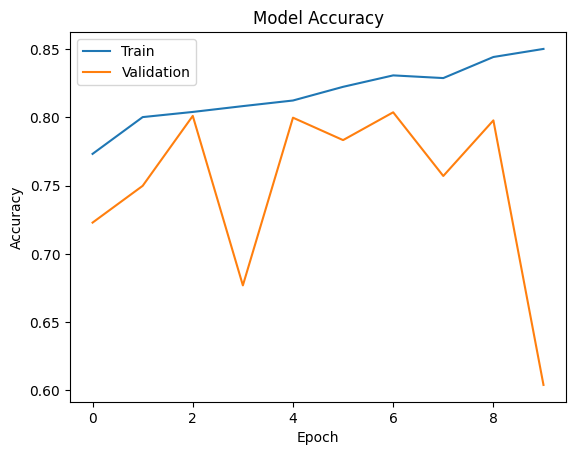

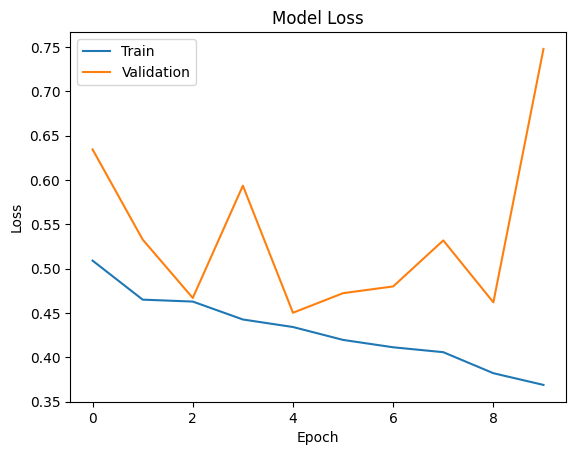

In [41]:
# plot the metrics
import matplotlib.pyplot as plt

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

From the 2nd iteration of training we can see this time, the model became much more unstable.

According to accuracy we can see our model converged around the 3rd epoch, and from loss we see the model then soon diverged thereafter, at the 9th epoch the model is severly overfitted.

In the next iteration, I think we should tune the hyper parameter, reduce the learning rate and maybe add dropouts for the lstm layer.

### 5.3 Third iteration LSTM

In [42]:
# define our model
model3 = Sequential()

# define the mebedding layer
model3.add(Embedding(input_dim=len(t.word_index) + 1, 
                    output_dim=embedding_dim,
                    weights=[embedding_matrix], 
                    input_length=maxlen, 
                    trainable=False))
model3.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3)) # add dropout for lstm layer
model3.add(BatchNormalization())
model3.add(Dropout(0.5))
model3.add(Dense(1, "sigmoid"))

In [43]:
from keras.optimizers import Adam
# tune the optimizer 
optimizer = Adam(learning_rate = 0.0075)

# compile the model 
model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │       833,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 833,550 (3.18 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 833,550 (3.18 MB)

In [44]:
# start training
history3= model3.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=10)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.6288 - loss: 0.6896 - val_accuracy: 0.6566 - val_loss: 0.6071
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.6386 - loss: 0.6279 - val_accuracy: 0.6500 - val_loss: 0.6097
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.6224 - loss: 0.6444 - val_accuracy: 0.5772 - val_loss: 0.6817
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.5506 - loss: 0.6958 - val_accuracy: 0.5772 - val_loss: 0.6835
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.5577 - loss: 0.6888 - val_accuracy: 0.5772 - val_loss: 0.6822
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.5489 - loss: 0.6903 - val_accuracy: 0.5772 - val_loss: 0.6810
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.5597 - loss: 0.6864 - val_accuracy: 0.5772 - val_loss: 0.6815
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.5646 - loss: 0.6859 - val_acc

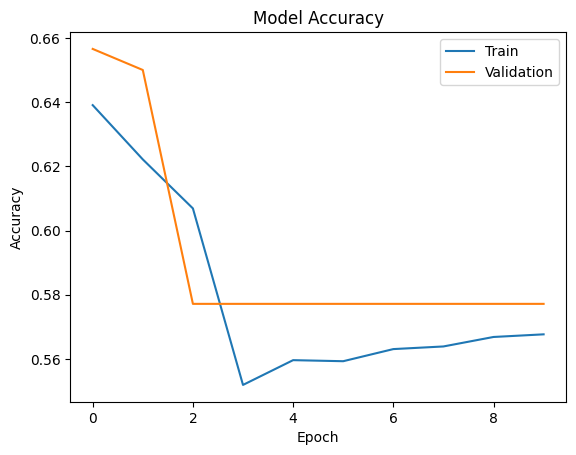

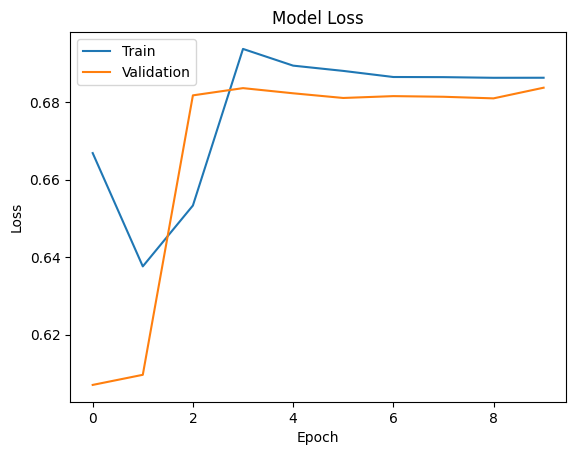

In [45]:
# plot the metrics
import matplotlib.pyplot as plt

plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

Although both accuracy and loss had converged in the third iteration, and appears to be very stable. But the accuracy is lower and loss is higher compare to the previous iterations. This seems like the learning rate we set was too low.

I think so far the best model is our basic model.

## 6. Submission

In [46]:
# make prediction using model2
pred = model.predict(padded_test)
print(pred)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
[[0.6979381 ]
 [0.6593142 ]
 [0.7610942 ]
 ...
 [0.7232521 ]
 [0.56346023]
 [0.4948724 ]]


In [50]:
# convert predicted probs into binary labs
pred_labs = (pred > 0.5).astype(int).flatten()
print(pred_labs)

[1 1 1 ... 1 1 0]


In [51]:
# prepare submission df
sub_df = pd.DataFrame({
    "id": test_df["id"],
    "target": pred_labs
})
sub_df.to_csv('submission.csv', index=False)

In [53]:
from IPython.display import FileLink
FileLink(r'submission.csv')

/kaggle/working/submission.csv

## 7. Conclusion

In the end our submission obtained a score of 0.78, which fits the model performance as we have seen in the training and validation process.

Trainnig RNN apparently is not an easy thing. Both overfitting and underfitting can present and disrupt the balance of your model while you are trying to balance one and another.

Some of the next steps to explore to improve our model:
1. Increase (restore) the learning rate
2. Adjust the dropout rate
3. Implement call back methods to stop training early